<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/Application/Classification_automation_SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The objectives of this notebook are:

+ Conduct scientific literature searches on [Semantic Scholar](https://www.semanticscholar.org/) utilizing the [S2Query](https://github.com/BecomeAllan/S2Query) package.
+ Utilizing the [ML-SLRC](https://github.com/BecomeAllan/ML-SLRC/blob/main/Meta_learning_EFL.ipynb) model to include/exclude articles from a systematic literature review.

# GPU

How to set the notebook to use GPU for train the model https://youtu.be/4z9mIAZixrU?t=104

# Dependencies required


In [1]:
%%capture
!pip install S2query==1.0.3.2
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!git lfs install
!git clone https://huggingface.co/becomeallan/ML-SLRC
!pip install crossrefapi

# !pip install matplotlib==3.5.1

In [14]:
from itertools import chain
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import HTML, display, clear_output, Markdown

%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path
from crossref.restful import Works
import requests

import sys

sys.path.append("/content/ML-SLRC/")

path = "/content/ML-SLRC/"

model_path = path + "model.pt"
info_path = path + "Info.json"


from Util_funs import train_loop, prepare_data, SLR_Classifier, Encoder, SLR_DataSet

# Kind of device to utilize the model on  (GPU, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the model
model = torch.load(model_path)

# Loading meta info of the trained model
with open(info_path, "r") as f:
    Info = json.load(f)

# Configuring some of the meta info
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info["model"], do_lower_case=True)
Info["threshold"] = 0.9
Info["inner_update_step_eval"] = 4
Info["inner_print"] = 1
Info["inner_batch_size"] = 4
Info['inner_update_step'] = 4
Info['inner_update_lr'] = 0.00005
Info['pos_weight'] = 2.5
Info["weight_decay"] = 0.85


model.loss_fn = nn.BCEWithLogitsLoss(reduction = 'mean',
                                        pos_weight=torch.FloatTensor([Info['pos_weight']]))


# Semantic Scholar Query

In order to conduct the literature search, two functions can be used:

+ `SearcherAPI`: Search through the Semantic Scholar API.
+ `SearcherWeb`: Search by scraping the Semantic Scholar website.

Within the search functions, keywords must be specified utilizing **single quotation marks**: `'keyword'`. Additionally, `+` and `-` signs can be used to include and exclude, respectively, keywords from the search, and must be no space between the signs.

Example: `'artificial intelligence'+'Deep Learning'-'Biology'`



## Using the API to search for data

Within the available parameters:

+ `Query`: Search words such as titles or keywords
+ `Number of papers`: Number of results to be returned, as many as 10,000.

Upon providing these parameters, use the `Search` button to conduct the search. Once it's finished, the `Export Articles` and `Export All` buttons will save the data, considering scientific articles only or all fetched data, respectively.

+ `Export Articles` saves as .csv: `data_API_Articles.csv`.
+ `Export All` saves as .csv: `data_API.csv`.

In [3]:
# @title SearcherAPI
from S2query import S2paperAPI
from multiprocessing import Pool

# Search interface using SS API
class SearcherAPI:
    def __init__(self):
        # Creates data fetching object
        self.obj = S2paperAPI()
        self.find = False
        self.save_b = widgets.Button(description="Export Articles")
        self.save_b.on_click(self.post_processing)
        self.save_all_b = widgets.Button(description="Export All")
        self.save_all_b.on_click(self.save_data)

        # Creating buttons and textbox
        self.search_b = widgets.Button(description="Search")
        self.search_text = widgets.Textarea(
            description=" : Query",
            value="'artificial intelligence'+'Deep Learning'-'Biology'",
            placeholder="Type something",
            layout=Layout(
                width="50%", height="60px", display="flex", flex_flow="row-reverse"
            ),
            # description=':',
            disabled=False,
        )

        self.number_papers = widgets.IntText(
            value=100,
            min=2,
            # layout = widgets.Layout(width='180px'),
            style={"description_width": "initial"},
            layout=Layout(width="180px", display="flex", flex_flow="row-reverse"),
            description=" Number of papers",
            disabled=False,
        )

        # self.leftbox = widgets.HBox([self.search_text])
        self.rightbox = widgets.VBox(
            [self.search_text, self.number_papers, self.search_b]
        )

        # self.hbox = widgets.HBox([self.leftbox, self.rightbox])
        self.save_h = widgets.HBox([self.save_b, self.save_all_b])

        # On click function
        self.search_b.on_click(self.search_button)

    # Search button
    def search_button(self, p):
        print(self.search_text.value)
        # Searches data
        self.obj.get(
            self.search_text.value,
            n=self.number_papers.value,
            fields = ['externalIds', 'paperId', 'url', 'title', \
                        'abstract', 'venue', 'year', 'referenceCount', \
                        'citationCount', 'influentialCitationCount', \
                        'isOpenAccess', 'fieldsOfStudy', 'authors']
        )

        # Saves data found
        self.data = self.obj.all
        self.extract_info()

        # self.data

        self.find = True
        self.__call__()


    def extract_info(self):
        self.data = self.data.rename(columns={"externalIds": "doi"})
        doi = [d.get("DOI") for d in self.data.doi]
        self.data["doi"] = doi
        null = self.data.doi.isnull().values
        self.data = self.data.drop(self.data[null].index)
        self.data = self.data[self.data.doi != ""]
        self.data['authors'] = self.data.authors.map(lambda author: [contex['name']  for contex in author ] if len(author) != 0 else author)
        self.data = self.data[self.data.doi != ""]

    def doi2bib(self, doi):
        """
        Return a bibTeX string of metadata for a given DOI.
        """

        url = "http://dx.doi.org/" + doi

        headers = {"accept": "application/x-bibtex"}
        r = requests.get(url, headers = headers)

        return r.text



    def post_processing(self, p):
        self.works = Works()
        docs_type = []
        bibtex = []

        dois = self.data.doi.to_list()

        # with Pool(2) as p:
        #   docs_type = p.map(self.multiprocessing, dois)

        print("processing ...")

        for doi in dois:
            try:
                t = self.works.doi(doi)["type"]
                bibtex.append(self.doi2bib(doi))
            except:
                t = ""
                bibtex.append(t)
            docs_type.append(t)

        self.data["type"] = docs_type
        self.data["bibtex"] = bibtex
        mask = ["journal-article", "proceedings-article"]
        self.data_article = self.data[self.data["type"].isin(mask)]
        self.data_article = self.data_article.reset_index().drop("index", axis=1)
        self.data_article.to_csv("data_API_Articles.csv")
        self.__call__()
        print("Saved as data_API_Articles.csv")

    def save_data(self, p):
        self.data.to_csv("data_API.csv")
        self.__call__()
        print("Saved as data_API.csv")

    def multiprocessing(self, data):
        try:
            t = self.works.doi(data)["type"]
        except:
            t = ""

        return t

    # Call function
    def __call__(self):
        clear_output()
        # Displaying buttons
        display(self.rightbox)
        if self.find:
            display(self.save_h)


In [4]:
resultAPI = SearcherAPI()
resultAPI()

Saved as data_API_Articles.csv


In [6]:
resultAPI.data.head(2)

,paperId,doi,url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors
0,cff0c93a6a372e239a8de20283a464460c610941,10.1016/j.ejmp.2021.03.009,https://www.semanticscholar.org/paper/cff0c93a...,Artificial intelligence: Deep learning in onco...,None,Physica medica : PM : an international journal...,2021,118,30,0,False,[Medicine],"[P. Papadimitroulas, L. Brocki, Neo Christophe..."
1,770b919f47185b1bfbf3f18fad2a27191a608b31,10.1016/j.ejmp.2021.03.008,https://www.semanticscholar.org/paper/770b919f...,The promise of artificial intelligence and dee...,None,Physica medica : PM : an international journal...,2021,152,46,0,False,[Medicine],"[Hossein Arabi, A. Akhavanallaf, Amirhossein S..."


## Using the SS website to search for data

Besides the keywords text box, the following parameters are available:

+ `Number of papers`: Number of papers to be returned.
+ `Sort by`: Sorting criteria for results.
+ `min./max year`: Year of publication.
+ `venue`: Publication venue.
+ `Publication`: Kind of publication (JournalArticle is recommended).
+ `fieldsOfStudy`: Fields of study.

Upon providing these parameters, use the `Search` button to conduct the search. Once it's finished, the `Export Data` button will save all results as .csv: `data_API.csv`

In [7]:
#@title SearcherWeb
from S2query import S2paperWeb

# Interface de busca utilizando a Web do SS
class SearcherWeb():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperWeb()
    self.find = False


    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence'+'Deep Learning'-'Biology'",
    placeholder='Type something',
    layout=Layout(width='50%', height='60px',
                  display= 'flex', flex_flow= 'row-reverse'),
    # description=':',
    disabled=False
)
        # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


    self.save_all_b = widgets.Button(description="Export Data")
    self.save_all_b.on_click(self.save_data)

    # Configura opcoes possiveis do parametro sort
    self.sort = widgets.Dropdown(
    options = ["total-citations", "influence", "pub-date", "relevance"],
    value = 'relevance',
    description = 'Sort by',
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    disabled = False
)
    
    # Configura opcoes possiveis do parametro venue
    self.venue = widgets.SelectMultiple(
    options=["PloS one", "AAAI", "Scientific reports", "IEEE Access", \
             "ArXiv", "Expert Syst. Appl.""ICML", "Neurocomputing", \
             "Sensors", "Remote. Sens."],
    value=[],
    layout=Layout(width='300px'),
    #rows=10,
    description='venue',
    disabled=False
)
    
        # Criando um botao de selecionar todos
    # para as venues
    self.but_venue = widgets.Button(description = 'All venues')

    self.but_venue.on_click(self.venue_button)

    # Configura as opcoes do parametro yearFilter
    self.min = widgets.IntText(
    description='Min. year: ',
    value=2000,
    disabled=False
)

    self.max = widgets.IntText(
    description='Max. year: ',
    value=2022,
    disabled=False
)
    


    # Configura as opcoes do parametro publicationTypes
    self.pubtype = widgets.SelectMultiple(
    options=["ClinicalTrial","CaseReport","Editorial","Study", "Book",\
             "News","Review","Conference","LettersAndComments",\
             "JournalArticle"],
    value=["JournalArticle"],
    #rows=10,
    description='Publication',
    disabled=False
)
    
    # Criando um botao de selecionar todos
    # para as venues
    self.but_pub = widgets.Button(description = 'All pub. types')

    self.but_pub.on_click(self.pub_button)

    # Configura as opcoes do parametro fieldsOfStudy
    self.fos = widgets.SelectMultiple(
    options=["agricultural-and-food-sciences","art","biology",\
             "business","computer-science","chemistry","economics",\
             "education","engineering","environmental-science",\
             "geography","geology","history","law","linguistics",\
             "materials-science","mathematics","medicine","philosophy",\
             "physics","political-science","sociology","psychology"],
    value=[],
    #rows=10,
    description='fieldsOfStudy',
    disabled=False
)

    # Criando um botao de selecionar todos
    # para as venues
    self.but_fos = widgets.Button(description = 'All fields')

    self.but_fos.on_click(self.fos_button)

    self.number_papers = widgets.IntText(
    value=100,
    min=2,
    # layout = widgets.Layout(width='180px'),
    style= {'description_width': 'initial'},
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    description=' Number of papers',
    disabled=False)

    # self.leftbox = widgets.HBox([self.search_text])
    self.vbox1 = widgets.VBox([self.sort, self.number_papers])
    self.hbox1 = widgets.HBox([self.search_text, self.vbox1])
    self.hbox2 = widgets.HBox([self.min, self.max])
    self.hbox3 = widgets.HBox([self.venue, self.but_venue])
    self.hbox4 = widgets.HBox([self.pubtype, self.but_pub])
    self.hbox5 = widgets.HBox([self.fos, self.but_fos])
    
    self.Vbox = widgets.VBox([self.hbox1,
                              self.hbox2,
                              self.hbox3,
                              self.hbox4,
                              self.hbox5,
                              self.search_b
                              ])
    

  # Search button
  def search_button(self, p):
    # self.__call__()
    
    print(self.search_text.value)
    # Busca os dados


    self.yearfilter = {"min": self.min.value, "max": self.max.value}
    self.obj.get(self.search_text.value,
                 n=self.number_papers.value,
                 sort = self.sort.value,
                 venue = self.venue.value,
                 yearFilter = self.yearfilter,
                 publicationTypes = self.pubtype.value,
                 fieldsOfStudy = self.fos.value)


    # Guarda os dados achados
    self.data = self.prepare_data(self.obj.all)
    self.find = True
    self.__call__()

    # print("done")
  
  # Definindo a funcao do botao de field of study
  def fos_button(self, p):

    self.fos.value = self.fos.options

  # Definindo a funcao do botao de venue
  def venue_button(self, p):

    self.venue.value = self.venue.options

  # Definindo a funcao do botao de pubtype
  def pub_button(self, p):

    self.pubtype.value = self.pubtype.options
  # cria um subset dictionary da funcao que busca os dados
  def subset(self, dicttosub):
    # Seleciona apenas as colunas
    subdict = {k:dicttosub[k] for k in ('title','paperAbstract',
                                        'year', 'primaryPaperLink',
                                        'entities', 'fieldsOfStudy',
                                        'authors', 'citationStats')}

    # Renomeia a key do dictionar
    subdict['abstract'] = subdict.pop('paperAbstract')
    subdict['numReferences'] = subdict['citationStats']['numReferences']
    subdict['numCitations'] = subdict['citationStats']['numCitations']
    subdict.pop('citationStats')
    
    # Guarda apenas um link de referencia
    try:
      subdict['link'] = subdict['primaryPaperLink']['url']
    except:
      subdict['link'] = np.nan

    subdict.pop('primaryPaperLink')

    return subdict

  
  def save_data(self, p):
    self.data.to_csv("data_WEB.csv")
    self.__call__()
    print("Saved as data_WEB.csv")

  # Trata os dados para transformar de json para pandas.dataframe
  def prepare_data(self, data):

    # Loop sobre os resultados para selecionar tudo em uma lista
    papers = []
    for x in data['Results']:
      papers_page = [self.subset(paper) for paper in x['Page']['Papers']]
      papers.append(papers_page)
    papers = list(chain.from_iterable(papers))

    # Transforma em Pandas
    data = pd.DataFrame(papers)
    return data
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.Vbox)
    if self.find:
      display(self.save_all_b)

In [8]:
resultWEB = SearcherWeb()
resultWEB()

Button(description='Export Data', style=ButtonStyle())

In [9]:
resultWEB.data.head(2)

,title,year,entities,fieldsOfStudy,authors,abstract,numReferences,numCitations,link
0,Artificial intelligence: Deep learning in onco...,2021,[],[Computer Science],"[P. Papadimitroulas, L. Brocki, Neo Christophe...",,118,30,https://www.ncbi.nlm.nih.gov/pubmed/33765601
1,The promise of artificial intelligence and dee...,2021,[],[Physics],"[Hossein Arabi, A. Akhavanallaf, Amirhossein S...",,152,46,https://www.ncbi.nlm.nih.gov/pubmed/33765602


# Training the model on labeling

In [17]:
# @title Data classifying and model training functions

from scipy import stats
import matplotlib.patches as mpatches

from ipywidgets import GridspecLayout, Label
from scipy.stats import poisson

class Judger:
    def __init__(self, data, configure_text=True):
        self.data = data.copy()
        self.selected_indx = []
        self.index = 0

        # Density distribution to sample for labeling
        density = poisson.pmf(range(len(self.data)), mu=10)
        density[density == 0] = min(density[density != 0])

        # Randomizing indexes
        self.shuffle = np.random.choice(
            range(len(data)), p=density, replace=False, size=len(data)
        )
        self._id = self.shuffle[self.index]
        # self._id = self._id

        if configure_text:
            # Creating 'text' column uniting title and abstract
            self.data.abstract.fillna(value="", inplace=True)
            self.data.title.fillna(value="", inplace=True)
            self.data["text"] = self.data["title"] + ". " + self.data["abstract"]


        if any(self.data.columns.isin(["label"])):
            self.data["label"] = self.data["label"].replace(
                {
                    "negative": "Not Included",
                    "0": "Not Included",
                    "excluded": "Not Included",
                    0: "Not Included",
                    1: "Included",
                    "1": "Included",
                    "positive": "Included",
                    '': np.nan
                }
            )
            ok = 1
        else:
            self.data["label"] = np.nan

        # Buttons
        self.next_b = widgets.Button(description="Next")
        self.previous_b = widgets.Button(description="Previous")
        self.Included = widgets.Button(description="Included", style= {'text_color': '#000000', 'button_color' : 'lightgreen'} )
        self.NIncluded = widgets.Button(description="Not Included", style= {'text_color': '#000000','button_color' : '#FF8C73'})
        self.erase_b = widgets.Button(description="Erase Label")
        self.current_example = widgets.IntSlider(
            value=1,
            min=1,
            max=len(self.data),
            step=1,
            # description='Current example:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout_format='d',
            layout = Layout(width='300px'),
            readout=True
            # style = {'description_width': 'initial'}
        )
        # out1 = widgets.Output()
        self.out1 = widgets.HTML(value=f'{self.current_example.value}' )
        self.out2 = widgets.HTML(value=f'/ {len(self.data)}')

        self.box_slider =  widgets.HBox([Label('Current example:'), self.current_example, self.out2])


        # On click functions
        self.next_b.on_click(self.next_button)
        self.previous_b.on_click(self.prev_button)
        self.Included.on_click(self.Included_button)
        self.NIncluded.on_click(self.Not_Included_button)
        self.erase_b.on_click(self.erase_button)

        # Button placement configuration
        self.Judger_hbox1 = widgets.HBox([self.NIncluded, self.Included])
        self.Judger_hbox2 = widgets.HBox([self.erase_b,self.previous_b, self.next_b])
        self.Judger_grid = widgets.VBox([self.Judger_hbox1, self.Judger_hbox2])

    # Include in review button
    def Included_button(self, p):
        
        self.data.loc[self._id, "label"] = "Included"
        
        # id = self._id + 2
        # cell_list = sheet.range(f'A{id}:J{id}')
        # i = 6
        # cell_list[i].value = "Sim"
        # sheet.update_cells(cell_list)

        try:
            self.index += 1
            self._id = self.shuffle[self.index]
            text = self.data.loc[self._id, "text"]
        except:
            self.index = 0
            self._id = self.shuffle[self.index]
            
        self.__call__()

    # Exclude from review button
    def Not_Included_button(self, p):
        self.data.loc[self._id, "label"] = "Not Included"

        # id = self._id + 2
        # cell_list = sheet.range(f'A{id}:J{id}')
        # i = 6
        # cell_list[i].value = "Não"

        # for i, val in enumerate(cell_values):
        #     cell_list[i].value = val 

        # sheet.update_cells(cell_list)


        try:
            self.index += 1
            self._id = self.shuffle[self.index]
            text = self.data.loc[self._id, "text"]
        except:
            self.index = 0
            self._id = self.shuffle[self.index]
        self.__call__()

    # Erase label button
    def erase_button(self, p):
        text = self.data.loc[self._id, "text"]
        self.data.loc[self._id, "label"] = np.nan

        # id = self._id + 2
        # cell_list = sheet.range(f'A{id}:J{id}')
        # i = 6
        # cell_list[i].value = "Sim/Não"
        # sheet.update_cells(cell_list)

        self.__call__()

    # Next button
    def next_button(self, p):
        # Checks if it's possible to go to the next text
        try:
            self.index += 1
            self._id = self.shuffle[self.index]
            text = self.data.loc[self._id, "text"]
        except:
            self.index = 0
            self._id = self.shuffle[self.index]
        self.__call__()

    # Prev button
    def prev_button(self, p):
        # Checks if it's possible to go to the previous text
        if self.index - 1 < 0:
            self.index = len(self.data) - 1
            self._id = self.shuffle[self.index]
        else:
            self.index -= 1
            self._id = self.shuffle[self.index]
        self.__call__()

    def update_slider(self, change):
      clear_output()
      self.index = change['new'] - 1
      self.out1.value = f"{change['new']}"
      self._id = self.shuffle[self.index]
      self.__call__()

    # Call function
    def __call__(self):
        clear_output()
        # Unlabeled data
        criteria_na = self.data["label"].isna()
        # If all data is labeled
        # if sum(criteria_na) == 0 or self.index > len(self.data):
        # return print('Finished')

        self.current_example.value = self.index + 1
        self.current_example.observe(self.update_slider, names='value')
        clear_output()
        # print(self.current_example.value)



        # Random index to pick an article to be classified
        indexs_unlabeled = self.data.loc[criteria_na].index

        # Saving chosen index
        self.selected_indx.append(self.index)

        # Text and label for this index
        text = self.data.loc[self._id, "text"]
        # print(text)
        label = self.data.loc[self._id, "label"]

        statistics = self.data["label"].value_counts()

        try:
            neg = statistics["Not Included"]
        except:
            neg = 0
        try:
            pos = statistics["Included"]
        except:
            pos = 0

        self.pos = pos
        self.neg = neg

        
        # self.index = self.current_example.value

        print("---"*30)
        print(f"Unlabeled: {sum(criteria_na)} ({round((sum(criteria_na))/len(self.data)*100,2) }%)")
        print(f"Labaled {(neg+pos)} ({round((neg+pos)/len(self.data)*100,2) }%)")
        print(f"  Not included examples: {neg} ({round((neg)/len(self.data)*100,2)}%)")
        print(f"  Included examples: {pos} ({round((pos)/len(self.data)*100,2)}%)")
        print("---"*20)
        # print()



        display(self.box_slider)
        # print(f"Current example: {self.index+1} / {len(self.data)}")
        display(self.Judger_hbox2)
        # display(self.Judger_grid)
        print('index:',self._id)
        print("Label:", label)

        print("Text:")
        display(Markdown(text))
        display(self.Judger_hbox1)
        # display(self.Judger_grid)



class Train:
    def __init__(self, model, data, device, Info):
        self.data = data
        self.model = model
        self.Info = Info
        self.device = device
        self.trained = False
        self.index = 0

        # Buttons
        self.train_b = widgets.Button(description="Train")
        self.number_class = widgets.IntText(
            value=2,
            min=2,
            layout=widgets.Layout(width="150px"),
            style={"description_width": "initial"},
            description="Size per class:",
            disabled=False,
        )
        self.value_trash = widgets.FloatText(
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            description="Confidence Level:",
            layout=widgets.Layout(width="170px"),
            style={"description_width": "initial"},
            disabled=False,
        )

        # Button placement configuration
        self.Train_hbox = widgets.HBox(
            [self.train_b, self.number_class, self.value_trash]
        )

        # On click functions
        self.train_b.on_click(self.train_button)
        self.treshold = self.value_trash.value

    # Train button
    def train_button(self, p):
        clear_output()
        print("Training...")
        # Pre-processing text data before feeding to model
        test_batch_size = 100 if len(self.data) > 100 else len(self.data)

        try:
            (
                self.data_train_loader,
                self.data_test_loader,
                self.data_train,
                self.data_test,
            ) = prepare_data(
                self.data,
                train_size_per_class=self.number_class.value,
                batch_size={
                    "train": self.Info["inner_batch_size"],
                    "test": test_batch_size,
                },
                max_seq_length=self.Info["max_seq_length"],
                tokenizer=self.Info["tokenizer"],
                input="text",
                output="label",
            )

        except:
            self.__call__()
            print("Try another size per class")
            return

        # Trains model and gets classifier layer vector
        self.logits = train_loop(
            self.data_train_loader,
            self.data_test_loader,
            self.model,
            self.device,
            epoch=self.Info["inner_update_step"],
            lr=self.Info["inner_update_lr"],
            print_info=True,
            name="test",
            weight_decay = self.Info["weight_decay"]
        )

        # Sigmoid to assert predictions to 0 and 1
        predictions = torch.sigmoid(self.logits)

        # Saving predictions for test data
        self.data_test["prediction"] = predictions
        self.data = self.data_test

        self.trained = True
        self.__call__()
        print("Done")

    def __call__(self):
        print()
        display(self.Train_hbox)


class Interface(Judger, Train):
    def __init__(self, data):
        Judger.__init__(self, data)
        Train.__init__(self, model, self.data, device, Info)

        # Buttons
        self.evaluation_b = widgets.Button(description="Evaluation")
        self.export_b = widgets.Button(description="Export data")
        self.reord_b = widgets.Button(description="Reorder data")
        self.rank_b = widgets.Button(description="Rank data")

        # On click functions
        self.evaluation_b.on_click(self.evaluation_button)
        self.export_b.on_click(self.export_button)
        self.reord_b.on_click(self.model_order_button)
        self.rank_b.on_click(self.rank_button)

        # Button placement configuration
        self.evaluate0 = widgets.HBox([self.export_b, self.rank_b, self.reord_b ])
        self.evaluate1 = widgets.HBox([self.evaluation_b ])
        self.evaluate = widgets.VBox([self.evaluate0, self.evaluate1])

    # Reordering data
    def model_order_button(self, p):
        kernel = stats.gaussian_kde(self.data["prediction"])
        prob = 1 / kernel(self.data["prediction"])
        prob = prob / sum(prob)
        self.shuffle = np.random.choice(
            range(len(self.data)), size=len(self.data), replace=False, p=prob
        )

        self._id = self.shuffle[self.index]
        
        self.__call__()

    # rank data
    def rank_button(self, p):
        self.data = self.data.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
        # print()

        self.shuffle = list(range(len(self.data)))

        self._id = self.shuffle[self.index]
        # self._id = 0
        
        self.__call__()

    # Evaluating data distribution
    def evaluation_button(self, p):

        self.treshold = self.value_trash.value

        _, _, bars = plt.hist(self.data["prediction"], color="C0")

        for bar in bars:
            if bar.get_x() > self.treshold:
                bar.set_facecolor("C1")
        plt.title("Number of papers by Confidence level")
        plt.xlabel("Confidence level")
        plt.ylabel("Number of papers")

        n_incl = sum(self.data["prediction"] >= self.treshold)
        n_notincl = sum(self.data["prediction"] < self.treshold)

        Inc = mpatches.Patch(color="C1", label=f"(Model) Included: {n_incl}")
        notInc = mpatches.Patch(color="C0", label=f"(Model) Not Included: {n_notincl}")

        plt.legend(handles=[Inc, notInc])
        plt.axvline(self.treshold, color="red", linestyle="dashed", linewidth=1)
        self.__call__()

        plt.show()

    # Saving data
    def export_button(self, p):
        data = self.data
        data["model_label"] = (data["prediction"] > self.treshold) * 1

        if 'confidence' in data.columns.values:
          data['confidence'] = data["prediction"]
          data.drop('prediction', axis=1)
        else:
          data = data.rename(columns={"prediction": "confidence"})
        
        data = data.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
        data['rank'] = list(range(1,len(data)+1))

        data.to_csv("data.csv")

        self.__call__()
        print("Saved as data.csv")

    # Call function
    def __call__(self):

        Judger.__call__(self)
        if (self.pos >= 2) & (self.neg >= 2):
            if self.trained:
                prediction = self.data.loc[self._id, "prediction"]
                # Displaying some results
                print("Confidence:", prediction)
                print("(Model) Included:", self.treshold <= prediction)
                print("---"*20)
                display(self.evaluate)

            Train.__call__(self)
        print("---"*30)



To use the `Interface()` object, instance the object by passing data in `pandas.DataFrame` format, in which the `title` e `abstract` column must exist. If the data is already labeled, the labels must be in a `label` column, containing the following classifiers:

+ For included examples: "Included", "positive" or 1.
+ For not included examples: "Not Included", "excluded", "negative" or 0.

In order to use the model, it's necessary to conduct a first labeling round. For that, we have the following interface:

+ `Not Included`: Label the example as not included.
+ `Included`: Label the example as included.
+ `Previous`: Returns to previous example.
+ `Next`: Advances to next example.

The `Label` refers to the classification of the example given by the user based on the `text` of the current example, which is the concatenation of the title and abstract. 

After obtaining **2 included** and **2 not included** examples, the `Train` button will become available. The following configurations can be made:

+ `Size per class`: Number of examples per label
+ `Confidence Level`: Lowest confidence in which the model will classify as included, from 0 to 1.

Upon pressing `Train`, the model will be trained and used to label the data, and the following descriptors will be returned:

+ `Confidence`: Confidence attained by the model on whether to include or exclude an example.
+ `(Model) Included`: Label asserted by the model, based on the `Confidence Level` chosen.

After training the model, a few buttons for prediction evaluation will become available:

+ `Export data`: Export the data as `data.csv` based on `data` passed in `Interface(data)` with the `confidence`, `label` and `model_label` columns added, in which labels **1** and **0** identify **inclusion** and **exclusion**, respectively.
+ `Evaluation`: Creates a histogram of examples per confidence interval (`Confidence`), with a vertical line displaying the `Confidence Level`. Distributions close to 1 and 0 are expected, with 0 outnumbering 1.
+ `Reorder data`: Resample data order based on `confidence` density and returns a new order of examples, to evaluate `text` data individually.
+ `Rank data`: Sort the data based on `confidence`, to evaluate `text` data.

After training the model, it's possible to change labels, correcting or confirming the model's prediction, as a new training round. **We recommend 8 or more examples per label for better model performance.**

## Using data from `SearcherWeb()`



------------------------------------------------------------------------------------------
Unlabeled: 95 (95.0%)
Labaled 5 (5.0%)
  Not included examples: 2 (2.0%)
  Included examples: 3 (3.0%)
------------------------------------------------------------


index: 11
Label: nan
Text:


Spatial Metabolomics and Imaging Mass Spectrometry in the Age of Artificial Intelligence.. Spatial metabolomics is an emerging field of omics research that has enabled localizing metabolites, lipids, and drugs in tissue sections, a feat considered impossible just two decades ago. Spatial metabolomics and its enabling technology-imaging mass spectrometry-generate big hyper-spectral imaging data that have motivated the development of tailored computational methods at the intersection of computational metabolomics and image analysis. Experimental and computational developments have recently opened doors to applications of spatial metabolomics in life sciences and biomedicine. At the same time, these advances have coincided with a rapid evolution in machine learning, deep learning, and artificial intelligence, which are transforming our everyday life and promise to revolutionize biology and healthcare. Here, we introduce spatial metabolomics through the eyes of a computational scientist, review the outstanding challenges, provide a look into the future, and discuss opportunities granted by the ongoing convergence of human and artificial intelligence.

Confidence: 0.5523891
(Model) Included: True
------------------------------------------------------------


------------------------------------------------------------------------------------------


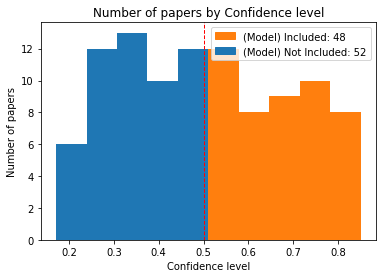

In [18]:
interface = Interface(resultWEB.data)
interface()

## Using data from `SearcherAPI()`



In [ ]:
interface = Interface(resultAPI.data_article) # data_article is after press Export Articles
interface()

## Example using another source data (Pseudo-Code)

In [ ]:
# Load data from another source
data_test = pd.read_csv('/content/SLRdata_test.csv')
data_train = pd.read_csv('/content/SLRdata_train_valid.csv')
data = pd.concat([data_train,data_test])

# Rename column with SLR decisions
data= data.rename(columns= {'decision':'label'})
# Reset index
data = data.reset_index()

In [ ]:
interface = Interface(data)
interface()

# Save data in Google Sheets 

The `spreadsheet_name` is the name of a new spreadsheet in [Google Sheets](https://workspace.google.com/intl/pt-BR/products/sheets/?utm_source=google&utm_medium=cpc&utm_campaign=latam-BR-all-pt-dr-skws-all-all-trial-e-dr-1011272-LUAC0011922&utm_content=text-ad-none-any-DEV_c-CRE_477535134213-ADGP_Hybrid%20%7C%20SKWS%20-%20EXA%20%7C%20Txt%20~%20Sheets_Spreadsheet-KWID_43700057667741410-kwd-11653031&utm_term=KW_spreadsheet-ST_spreadsheet&gclid=CjwKCAjw14uVBhBEEiwAaufYxz27yUv1PZLO_b-y4VyhQ0oc6l0XJLJAnImPGs4EYi-8uJD-VsR3bxoCZCkQAvD_BwE&gclsrc=aw.ds) saved on authentication login account after run the cell using the path passed in `data_path`.

In [ ]:
#@title Title of the spreadsheet
spreadsheet_name = "SLR_IA_DECISION" #@param {type:"string"}
data_path = "data.csv" #@param {type:"string"}

from google.colab import auth
import gspread
from gspread import Cell
import gspread_dataframe
from google.auth import default

# authentication
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# load spreadsheet
gc.create(spreadsheet_name)
wd = gc.open(spreadsheet_name)
url=  wd.fetch_sheet_metadata()['spreadsheetUrl']
sheet = wd.get_worksheet(0)

# Save
data = pd.read_csv(data_path)
gspread_dataframe.set_with_dataframe(sheet, data)


print(url)

## Load spreadsheet

In [ ]:
#@title Title of the spreadsheet
spreadsheet_name = "SLR_IA_DECISION" #@param {type:"string"}

In [ ]:
wd= gc.open(spreadsheet_name)
sheet = wd.get_worksheet(0)
data = sheet.get_all_records()
data = pd.DataFrame(data)

data.head()

,paperId,externalIds,url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors
0,cff0c93a6a372e239a8de20283a464460c610941,"{'DOI': '10.1016/j.ejmp.2021.03.009', 'CorpusI...",https://www.semanticscholar.org/paper/cff0c93a...,Artificial intelligence: Deep learning in onco...,,Physica medica : PM : an international journal...,2021,118,19,0,FALSE,['Medicine'],"[{'authorId': '6381045', 'name': 'P. Papadimit..."
1,770b919f47185b1bfbf3f18fad2a27191a608b31,"{'DOI': '10.1016/j.ejmp.2021.03.008', 'CorpusI...",https://www.semanticscholar.org/paper/770b919f...,The promise of artificial intelligence and dee...,,Physica medica : PM : an international journal...,2021,152,35,0,FALSE,['Medicine'],"[{'authorId': '2055830606', 'name': 'Hossein A..."
2,474c04fc0415b5e23566a203a7104c93b831a445,"{'PubMedCentral': '8470171', 'DOI': '10.3390/b...",https://www.semanticscholar.org/paper/474c04fc...,Artificial Intelligence Meets Marine Ecotoxico...,Simple Summary Our work is motivated by the in...,Biology,2021,39,2,0,FALSE,['Medicine'],"[{'authorId': '143921284', 'name': 'Nuno M. Ro..."
3,7eb57e6cc9bc99ce21adfdf4778736a6a44e8f7b,"{'PubMedCentral': '7864998', 'DOI': '10.1038/s...",https://www.semanticscholar.org/paper/7eb57e6c...,Unraveling the deep learning gearbox in optica...,,Communications biology,2021,120,4,0,FALSE,['Medicine'],"[{'authorId': '7184574', 'name': 'P. Maloca'},..."
4,c3699ca8359cc602aa0d1af2e25f9f288fa584e6,"{'MAG': '3081277636', 'DOI': '10.1088/1361-656...",https://www.semanticscholar.org/paper/c3699ca8...,Development and evaluation of a deep learning ...,Identification of prostate gold fiducial marke...,Physics in medicine and biology,2020,46,4,0,TRUE,"['Medicine', 'Computer Science']","[{'authorId': '39282313', 'name': 'C. Gustafss..."


# bibitex citation (EXTRA)

If the papers database have doi the follow function can retrive the bibtex citation

In [ ]:
def doi2bib(doi):
    """
    Return a bibTeX string of metadata for a given DOI.
    """

    url = "http://dx.doi.org/" + doi

    headers = {"accept": "application/x-bibtex"}
    r = requests.get(url, headers = headers)

    return r.text


doi2bib(doi)